#  Changepoint detection

The SPAD data is a 3-d array with axes (time,x,y), there are "Nbins" time bins, and if no photon is found this is indicated by a value greater than or equal to Nbins+1. "T" is the amount of time in each photon frame (1 over the frame rate).  

Change "data_path" to the data/2017 folder containing the fan data set to run this code

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 23 11:37:27 2020

@author: 19522
"""

import numpy as np
import matplotlib.pyplot as plt
from changepointClasses import * 
from deblurByTwosCode import *

data_path = '../../data/2017/'

file_list = ['20170328110549_pTOF_F.bin',
        '20170328110549_INT_F.bin',
        '20170502145930_pTOF_F_high.bin',
        '20170502145930_int_F_high.bin',
        '20170502145930_pTOF_F_low.bin',
        '20170502145930_int_F_low.bin',
        '20170502145930_pTOF_gray_high.bin',
        '20170502145930_int_gray_high.bin',
        '20170502145930_pTOF_gray_low.bin',
        '20170502145930_int_gray_low.bin',
        '20170503094851_pTOP_fan_move_high.bin',
        '20170503094851_int_fan_move_high.bin',
        '20170503094851_pTOP_fan_move_low.bin',
        '20170503094851_int_fan_move_low.bin',
        '20170503094851_pTOF_fan_still_high.bin',
        '20170503094851_int_fan_still_high.bin',
        '20170503094851_pTOF_fan_still_low.bin',
        '20170503094851_int_fan_still_low.bin',
        'PL_data_03.bin']

NFRAMES = None
XPIX = 32
YPIX = 32
PIXELS_PER_FRAME = XPIX*YPIX

def load_data(filename, nframes, nx, ny):
    """read a binary file generated by the 32x32 GM-APD array at 
    Martin's lab in ISL in France
    """

    mat = np.zeros((nframes, nx, ny))
    with open(filename, 'rb') as f:
        for i in range(nframes):
            cur_frame = np.fromfile(f, dtype=np.uint16, count=1056)
            cur_frame[cur_frame>8000] = 8001
            npix = nx*ny
            mat[i,:,:] = cur_frame[0:npix].reshape(nx,ny)
    return mat

def load_2017_dataset(set_number=1):
    """
    set_number should be a number 1 to 4 or 7, 8 or 11, 12
    For set numbers see table in Martin's Summary of ISL Datasets document
    returns a 3D matrix of size NFRAMES x XPIX x YPIX
    Note that pTOF datasets have 100k frames and INT datasets have 100 frames
    """
    if set_number not in [1,2,3,4,7,8,11,12,19]:
        print('data not available')
        return None
    else:
        filename = file_list[set_number-1]
        if 'pTOF' in filename or 'pTOP' in filename:
            NFRAMES = 100000
        else:
            NFRAMES=100
        #NFRAMES=400000
        return load_data(os.path.join(data_path,filename), NFRAMES, XPIX, YPIX)

In [2]:
fanData =load_2017_dataset(11)[:,3:] #loads data and removes dead pixels
fanData=fanData[:1000] #only looking at first part of video
Nbins = np.max(fanData)-1 #find Nbins
T = 2e-6 #2 microseconds 

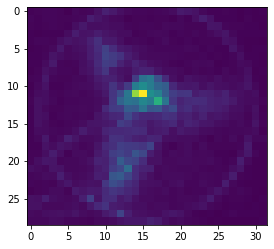

In [3]:
N = fanData<=8000
plt.imshow(sum(N[:100])/sum(fanData[:100]))#display first 100 photon frames average

In [4]:
#create a changepoint video, using penalty of 6 and solving with the pelt algorithms
#replace "pelt" with "bottomup" for faster, but less accurate results
cpv = ChangepointVideo(fanData,T,Nbins,penalty=6,cpSolver="pelt")
cpv.run_parallel(n_cores=30) #parallel run, using n_cores cpu cores
#cpv.run() #this runs not parallel

100%|██████████| 29/29 [00:19<00:00,  1.48it/s]


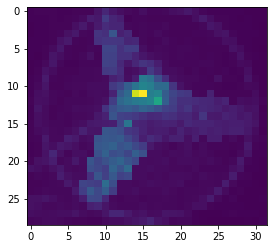

In [5]:
plt.imshow(cpv.getFluxFrame(100)) #access and plot the changepoint video at the time corresponding to the 100th photon frame

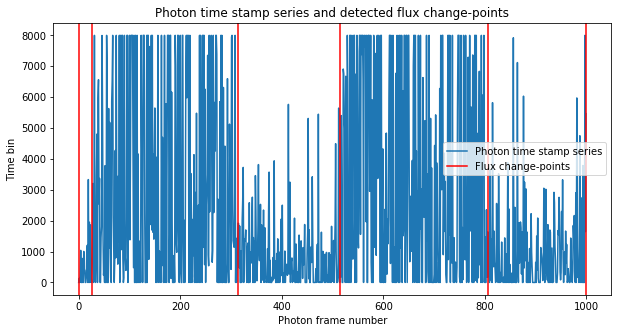

In [6]:
#plot a single pixel in time and show where the changepoints are found

plt.figure(figsize=(10,5))
plt.plot(fanData[:,10,9])
for i in cpv.singlePixels[10,9].edges:
    plt.axvline(i,color='red')
plt.title("Photon time stamp series and detected flux change-points")
plt.xlabel("Photon frame number")
plt.ylabel("Time bin")
plt.legend(["Photon time stamp series","Flux change-points"])

# Global Motion Deblurring

Recurrsivelly align and merges the data to compensate for global motion. The final image can sometimes be wrong if the motion is large and the object is symmetric (like the fan) because the last alignment fails.
Because of this we save the images at each step of the iteration in a file specified by the "file" argument.

In [29]:
#global motion deblurring with a variable frame rate on the changepoint video

#variable frame rate param. this .01 corresponds to waiting until 1% of pixels have a changepoint per CPV frame used in deblurring
cpsPercent =.01

#deblurs the whole video using alignment, and saves partial alignmets in a folder structure starting with the folder "file"
# the sub folders will indicate how many align and merges have taken place
flux_out, times_out,N_out=deblurByTwosStartVariableFRMulti(cpv,cpsPercent,fanData,n_cores=30,save=True,file="fan",n="fan")


#flux_out:final flux
#times_out: total of the deblurred times
#N_out: deblurred photon counts

#same us above but not multithreaded
#flux_out, times_out,N_out=deblurByTwosStartVariableFR(cpv,cpsPercent,fanData,save=True,file="fan",n="fan")

[0, 200, 402, 603, 803, 999]
(5, 29, 32)
looping
(2, 29, 32)
(1, 29, 32)


Checking the fan folder, notice that the last image in subfolder "0005" has matched the fan incorrectly, but subfolder "0004" contains good results. This is because the fan has made a full 1/3 loop and because of the symmetry of the fan the alignment fails. 

## Creating a Video

To create a video we do a moving deblurring window. This implementation is single core and does not use a variable frame rate, so it may be slow

In [22]:
fanData =load_2017_dataset(11)[:,3:] #loads data and removes dead pixels
fanData=fanData[:4000]

In [23]:
#will start the algorithm by sampling the CPV every 50 photon frames
initial_sampling = 50
#window width, this means each frame in the final video will use 400 photon frame
window_width =400
#window step size: this determines the frame rate.
step = 50
#scale factor: if we want to upscale to get better resolution images, scale factor of 1 does nothing
video=deblurByTwosMovingAvgStart(cpv,initial_sampling,fanData,step,window_width,scaleFactor=1)

100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


(8, 2, 3)
(8, 29, 32)
looping


  1%|▏         | 1/72 [00:19<22:42, 19.19s/it]

(29, 32)



100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


(8, 2, 3)
(8, 29, 32)
looping


  3%|▎         | 2/72 [00:34<20:59, 17.99s/it]

(29, 32)



100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


(8, 2, 3)
(8, 29, 32)
looping


  4%|▍         | 3/72 [00:45<18:19, 15.93s/it]

(29, 32)



100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


(8, 2, 3)
(8, 29, 32)
looping


  6%|▌         | 4/72 [00:59<17:20, 15.30s/it]

(29, 32)



100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


(8, 2, 3)
(8, 29, 32)
looping


  7%|▋         | 5/72 [01:15<17:21, 15.54s/it]

(29, 32)



100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


(8, 2, 3)
(8, 29, 32)
looping


  8%|▊         | 6/72 [01:31<17:22, 15.80s/it]

(29, 32)



100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


(8, 2, 3)
(8, 29, 32)
looping


 10%|▉         | 7/72 [01:48<17:14, 15.91s/it]

(29, 32)



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


(8, 2, 3)
(8, 29, 32)
looping


 11%|█         | 8/72 [02:06<17:55, 16.80s/it]

(29, 32)



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


(8, 2, 3)
(8, 29, 32)
looping


 12%|█▎        | 9/72 [02:24<18:02, 17.17s/it]

(29, 32)



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


(8, 2, 3)
(8, 29, 32)
looping


 14%|█▍        | 10/72 [02:40<17:18, 16.76s/it]

(29, 32)



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


(8, 2, 3)
(8, 29, 32)
looping


 15%|█▌        | 11/72 [02:56<16:42, 16.43s/it]

(29, 32)



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


(8, 2, 3)
(8, 29, 32)
looping


 17%|█▋        | 12/72 [03:12<16:23, 16.39s/it]

(29, 32)



100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


(8, 2, 3)
(8, 29, 32)
looping


 18%|█▊        | 13/72 [03:27<15:43, 15.99s/it]

(29, 32)



100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


(8, 2, 3)
(8, 29, 32)
looping


 19%|█▉        | 14/72 [03:43<15:26, 15.98s/it]

(29, 32)



100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


(8, 2, 3)
(8, 29, 32)
looping


 21%|██        | 15/72 [03:58<14:58, 15.77s/it]

(29, 32)



100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


(8, 2, 3)
(8, 29, 32)
looping


 22%|██▏       | 16/72 [04:08<12:56, 13.86s/it]

(29, 32)



100%|██████████| 8/8 [00:02<00:00,  3.65it/s]


(8, 2, 3)
(8, 29, 32)
looping


 24%|██▎       | 17/72 [04:15<10:51, 11.85s/it]

(29, 32)



100%|██████████| 8/8 [00:02<00:00,  3.66it/s]


(8, 2, 3)
(8, 29, 32)
looping


 25%|██▌       | 18/72 [04:26<10:20, 11.48s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00,  8.09it/s]


(8, 2, 3)
(8, 29, 32)
looping


 26%|██▋       | 19/72 [04:36<09:57, 11.28s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 42.68it/s]


(8, 2, 3)
(8, 29, 32)
looping


 28%|██▊       | 20/72 [04:45<09:06, 10.51s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 164.21it/s]


(8, 2, 3)
(8, 29, 32)
looping


 29%|██▉       | 21/72 [04:56<08:56, 10.52s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 162.61it/s]


(8, 2, 3)
(8, 29, 32)
looping


 31%|███       | 22/72 [05:04<08:18,  9.96s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 189.85it/s]


(8, 2, 3)
(8, 29, 32)
looping


 32%|███▏      | 23/72 [05:14<08:05,  9.92s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.34it/s]


(8, 2, 3)
(8, 29, 32)
looping


 33%|███▎      | 24/72 [05:23<07:35,  9.50s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.44it/s]


(8, 2, 3)
(8, 29, 32)
looping


 35%|███▍      | 25/72 [05:29<06:44,  8.61s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 193.84it/s]


(8, 2, 3)
(8, 29, 32)
looping


 36%|███▌      | 26/72 [05:37<06:20,  8.26s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.49it/s]


(8, 2, 3)
(8, 29, 32)
looping


 38%|███▊      | 27/72 [05:42<05:38,  7.51s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.61it/s]


(8, 2, 3)
(8, 29, 32)
looping


 39%|███▉      | 28/72 [05:48<05:09,  7.03s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 190.34it/s]


(8, 2, 3)
(8, 29, 32)
looping


 40%|████      | 29/72 [05:56<05:03,  7.07s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 190.80it/s]


(8, 2, 3)
(8, 29, 32)
looping


 42%|████▏     | 30/72 [06:04<05:08,  7.36s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.87it/s]


(8, 2, 3)
(8, 29, 32)
looping


 43%|████▎     | 31/72 [06:13<05:29,  8.04s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.28it/s]


(8, 2, 3)
(8, 29, 32)
looping


 44%|████▍     | 32/72 [06:20<05:10,  7.77s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 193.84it/s]


(8, 2, 3)
(8, 29, 32)
looping


 46%|████▌     | 33/72 [06:30<05:27,  8.39s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 163.89it/s]


(8, 2, 3)
(8, 29, 32)
looping


 47%|████▋     | 34/72 [06:40<05:39,  8.93s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 163.15it/s]


(8, 2, 3)
(8, 29, 32)
looping


 49%|████▊     | 35/72 [06:46<04:57,  8.04s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.67it/s]


(8, 2, 3)
(8, 29, 32)
looping


 50%|█████     | 36/72 [06:55<04:54,  8.17s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 162.53it/s]


(8, 2, 3)
(8, 29, 32)
looping


 51%|█████▏    | 37/72 [07:06<05:22,  9.21s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.48it/s]


(8, 2, 3)
(8, 29, 32)
looping


 53%|█████▎    | 38/72 [07:12<04:39,  8.22s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.62it/s]


(8, 2, 3)
(8, 29, 32)
looping


 54%|█████▍    | 39/72 [07:20<04:22,  7.96s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.38it/s]


(8, 2, 3)
(8, 29, 32)
looping


 56%|█████▌    | 40/72 [07:27<04:07,  7.72s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 190.62it/s]


(8, 2, 3)
(8, 29, 32)
looping


 57%|█████▋    | 41/72 [07:34<03:55,  7.60s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.21it/s]


(8, 2, 3)
(8, 29, 32)
looping


 58%|█████▊    | 42/72 [07:42<03:45,  7.52s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 190.26it/s]


(8, 2, 3)
(8, 29, 32)
looping


 60%|█████▉    | 43/72 [07:49<03:40,  7.60s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 164.78it/s]


(8, 2, 3)
(8, 29, 32)
looping


 61%|██████    | 44/72 [07:59<03:53,  8.35s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 164.26it/s]


(8, 2, 3)
(8, 29, 32)
looping


 62%|██████▎   | 45/72 [08:10<03:59,  8.87s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.54it/s]


(8, 2, 3)
(8, 29, 32)
looping


 64%|██████▍   | 46/72 [08:18<03:47,  8.75s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.00it/s]


(8, 2, 3)
(8, 29, 32)
looping


 65%|██████▌   | 47/72 [08:24<03:20,  8.00s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.01it/s]


(8, 2, 3)
(8, 29, 32)
looping


 67%|██████▋   | 48/72 [08:33<03:15,  8.15s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.09it/s]


(8, 2, 3)
(8, 29, 32)
looping


 68%|██████▊   | 49/72 [08:42<03:12,  8.37s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.03it/s]


(8, 2, 3)
(8, 29, 32)
looping


 69%|██████▉   | 50/72 [08:50<03:04,  8.41s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.43it/s]


(8, 2, 3)
(8, 29, 32)
looping


 71%|███████   | 51/72 [08:57<02:49,  8.05s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.35it/s]


(8, 2, 3)
(8, 29, 32)
looping


 72%|███████▏  | 52/72 [09:04<02:35,  7.77s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 189.40it/s]


(8, 2, 3)
(8, 29, 32)
looping


 74%|███████▎  | 53/72 [09:13<02:31,  7.97s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.11it/s]


(8, 2, 3)
(8, 29, 32)
looping


 75%|███████▌  | 54/72 [09:23<02:33,  8.53s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.41it/s]


(8, 2, 3)
(8, 29, 32)
looping


 76%|███████▋  | 55/72 [09:30<02:16,  8.03s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.78it/s]


(8, 2, 3)
(8, 29, 32)
looping


 78%|███████▊  | 56/72 [09:35<01:57,  7.36s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.00it/s]


(8, 2, 3)
(8, 29, 32)
looping


 79%|███████▉  | 57/72 [09:43<01:49,  7.29s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.02it/s]


(8, 2, 3)
(8, 29, 32)
looping


 81%|████████  | 58/72 [09:49<01:37,  6.93s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.02it/s]


(8, 2, 3)
(8, 29, 32)
looping


 82%|████████▏ | 59/72 [09:55<01:29,  6.88s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.04it/s]


(8, 2, 3)
(8, 29, 32)
looping


 83%|████████▎ | 60/72 [10:04<01:28,  7.39s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 190.01it/s]


(8, 2, 3)
(8, 29, 32)
looping


 85%|████████▍ | 61/72 [10:13<01:25,  7.76s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 190.70it/s]


(8, 2, 3)
(8, 29, 32)
looping


 86%|████████▌ | 62/72 [10:22<01:23,  8.38s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 192.06it/s]


(8, 2, 3)
(8, 29, 32)
looping


 88%|████████▊ | 63/72 [10:31<01:17,  8.58s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 189.22it/s]


(8, 2, 3)
(8, 29, 32)
looping


 89%|████████▉ | 64/72 [10:41<01:11,  8.95s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.33it/s]


(8, 2, 3)
(8, 29, 32)
looping


 90%|█████████ | 65/72 [10:48<00:58,  8.42s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 189.56it/s]


(8, 2, 3)
(8, 29, 32)
looping


 92%|█████████▏| 66/72 [10:57<00:51,  8.55s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 189.95it/s]


(8, 2, 3)
(8, 29, 32)
looping


 93%|█████████▎| 67/72 [11:06<00:42,  8.55s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.45it/s]


(8, 2, 3)
(8, 29, 32)
looping


 94%|█████████▍| 68/72 [11:12<00:31,  7.96s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 189.99it/s]


(8, 2, 3)
(8, 29, 32)
looping


 96%|█████████▌| 69/72 [11:22<00:25,  8.53s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 190.01it/s]


(8, 2, 3)
(8, 29, 32)
looping


 97%|█████████▋| 70/72 [11:31<00:17,  8.58s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.28it/s]


(8, 2, 3)
(8, 29, 32)
looping


 99%|█████████▊| 71/72 [11:38<00:08,  8.25s/it]

(29, 32)



100%|██████████| 8/8 [00:00<00:00, 191.70it/s]


(8, 2, 3)
(8, 29, 32)
looping


100%|██████████| 72/72 [11:47<00:00,  9.82s/it]

(29, 32)


In [25]:
np.shape(video)

(72, 29, 32)

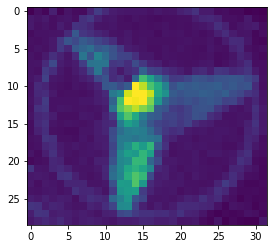

In [26]:
plt.imshow(video[0])

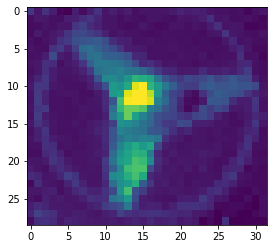

In [27]:
plt.imshow(video[10])